In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch

from pathlib import Path
from typing import Tuple, Dict, List
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models

In [2]:
MARGIN_SIZE = 32
HIDDEN_UNITS = 96

TRANSFORM_DATA_SIZE = (64, 64)
DATALOADER_BATCH_SIZE = 32
DATALOADER_TRAIN_SIZE = 0.20
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATASET_PATH = Path('dataset/test/')


MODEL_TRANSFORM = transforms.Compose([
	transforms.Grayscale(num_output_channels=3),
	transforms.Resize(size=TRANSFORM_DATA_SIZE),
	transforms.ToTensor(),
])

LETTERS_TRANSFORM = transforms.Compose([
	transforms.Grayscale(num_output_channels=3),
	transforms.Resize(size=TRANSFORM_DATA_SIZE),
	transforms.ToTensor(),
])

In [3]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
if DEVICE == 'cuda':
	torch.cuda.manual_seed(RANDOM_SEED)

In [4]:
def walk_through_images(top):
	result = dict()
	for dirpath, _, filenames in top.walk():
		if dirpath.stem != top.stem:
			info = {'filepath': dirpath, 'n_images': len(filenames)}
			result[dirpath.stem] = info
	return result

def images_train_test_split(image_paths=DATASET_PATH, train_size=DATALOADER_TRAIN_SIZE, random_seed=RANDOM_SEED):
	images_info = walk_through_images(image_paths)
	image_classes = len(images_info.keys())
	image_classes_map = dict(zip(images_info.keys(), range(image_classes)))
	
	images_train_target = []
	images_train_data = []
	
	images_test_target = []
	images_test_data = []
	
	for image_class, image_dataset in images_info.items():
		image_target = image_classes_map[image_class]
	
		n_images = image_dataset['n_images']
		n_train_images = int(train_size*n_images)
	
		random.seed(random_seed)
		images_filepath = list(image_dataset['filepath'].glob('*.jpeg'))
		random.shuffle(images_filepath)
	
		for n_image, filepath in enumerate(images_filepath):
			with Image.open(filepath) as image:
				image_data =  np.asarray(image)

			if n_image <= n_train_images:
				images_train_target.append(image_target)
				images_train_data.append(image_data)
			else:
				images_test_target.append(image_target)
				images_test_data.append(image_data)

	return images_train_data, images_test_data, images_train_target, images_test_target, list(image_classes_map.keys())

In [5]:
class ImageDataset(Dataset):
	def __init__(self, images, target, transform=None) -> None:
		self.images = images
		self.target = target
		self.transform = transform

	def __len__(self) -> int:
		return len(self.target)

	def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
		images_idx = self.transform(Image.fromarray(self.images[index]))
		target_idx = self.target[index]

		return images_idx, target_idx 

IMAGES_TRAIN_DATA, IMAGES_TEST_DATA, IMAGES_TRAIN_TARGET, IMAGES_TEST_TARGET, IMAGE_CLASSES = images_train_test_split()

IMAGE_TRAIN_DATASET = ImageDataset(IMAGES_TRAIN_DATA, IMAGES_TRAIN_TARGET, MODEL_TRANSFORM)
IMAGE_TEST_DATASET = ImageDataset(IMAGES_TEST_DATA, IMAGES_TEST_TARGET, MODEL_TRANSFORM)

In [6]:
def read_image_and_extract_letters(filepath):
	image = cv.imread(filepath)
	image = cv.rotate(image, cv.ROTATE_90_COUNTERCLOCKWISE)
	image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
	image = cv.medianBlur(image, 3)
	image = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 31, 11)

	kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
	image = cv.morphologyEx(image, cv.MORPH_CLOSE, kernel, iterations=3)

	image_contours, _ = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
	image_contours = sorted(image_contours, key=lambda image_contour: cv.boundingRect(image_contour)[0])

	image_letters = []
	for image_contour in image_contours:
		x, y, width, height = cv.boundingRect(image_contour)
		
		if width < 80 or height < 80:
			continue

		margin = MARGIN_SIZE
		image_letter = image[y-margin:y+height+margin, x-margin:x+width+margin].copy()
		image_letter = cv.bitwise_not(image_letter)
		image_letters.append(Image.fromarray(image_letter))

	return image_letters

In [7]:
def calculate_images_through_dir(top):
	for dirpath, _, filenames in top.walk():
		message = f"There are {len(filenames):>4} images in {dirpath}"
		print(message)

In [8]:
# TinyVGG 64x64
class TinyVGG_64x64(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, in_channels: int, hidden_units: int, out_features: int) -> None:
        super().__init__()
        self.tinymodel = nn.Sequential(
            # tinymodel conv2d block 1
			nn.Conv2d(in_channels, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

			# tinymodel conv2d block 1
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
			
	        # tinymodel classifier block
            nn.Flatten(),
            nn.Linear(hidden_units*16*16, out_features)
        )
    
    def forward(self, x: torch.Tensor):
        return self.tinymodel(x)

In [9]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               model_loss: torch.nn.Module,
               model_optimizer: torch.optim.Optimizer):

	model.train()
	train_loss, train_acc = 0, 0
    
	for X, y in dataloader:
		X, y = X.to(DEVICE), y.to(DEVICE)

		y_pred = model(X)
		loss = model_loss(y_pred, y)
		
		train_loss += loss.item()
		y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
		train_acc += 100*(y_pred_class == y).sum().item()/len(y_pred)
		
		model_optimizer.zero_grad()
		loss.backward()
		model_optimizer.step()

	train_loss /= len(dataloader)
	train_acc /= len(dataloader)
	
	return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              model_loss: torch.nn.Module,
              model_optimizer):
    
	model.eval()
	test_loss, test_acc = 0, 0

	with torch.inference_mode(): 
		for X, y in dataloader:
			X, y = X.to(DEVICE), y.to(DEVICE)
            
			y_pred = model(X)
			loss = model_loss(y_pred, y)

			test_loss += loss.item()
			y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
			test_acc += 100*(y_pred_class == y).sum().item()/len(y_pred)

		test_loss /= len(dataloader)
		test_acc /= len(dataloader)

		return test_loss, test_acc

In [10]:
def test_model_eval_on_random_image(image_paths, image_classes, model, transform, random_seed=RANDOM_SEED):
	random.seed(random_seed)
	image_path = random.choice(image_paths)
	image = Image.open(image_path)
	image_class = image_path.parent.stem

	model.eval()
	with torch.inference_mode():
		image_data = transform(image).unsqueeze(dim=0).to(DEVICE)
		image_pred = torch.argmax(torch.softmax(model(image_data), dim=1), dim=1)
	
	image_pred_class = image_classes[image_pred]
	image_data = transform(image).permute(1, 2, 0)

	print('Image path:', image_path)
	print('Image class:', image_class)
	print('Image predict class:', image_pred_class)

	fig, ax = plt.subplots(1, 2)
	ax[0].imshow(image)
	ax[0].set_title(f'Shape: ({image.width}, {image.height})')
	ax[1].imshow(image_data)
	ax[1].set_title(f'Shape: {TRANSFORM_DATA_SIZE}')

In [11]:
image_paths = list(DATASET_PATH.glob('*/*.jpeg'))

IMAGE_TRAIN_DATALOADER = DataLoader(dataset=IMAGE_TRAIN_DATASET, batch_size=DATALOADER_BATCH_SIZE, shuffle=True)
IMAGE_TEST_DATALOADER = DataLoader(dataset=IMAGE_TEST_DATASET, batch_size=DATALOADER_BATCH_SIZE)

image_classes = IMAGE_CLASSES
image_n_classes = len(image_classes)

In [12]:
# TinyVGG_64x64 for alphabet classification
model = TinyVGG_64x64(in_channels=3, hidden_units=HIDDEN_UNITS, out_features=image_n_classes).to(DEVICE)
model_loss = nn.CrossEntropyLoss()
model_optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3, weight_decay=1e-4)

In [13]:
image_letters = read_image_and_extract_letters('IMG.JPG')
image_letters_classes = ['А', 'В', 'Г', 'К', 'М', 'Н', 'Е']
image_n_letters = len(image_letters_classes)

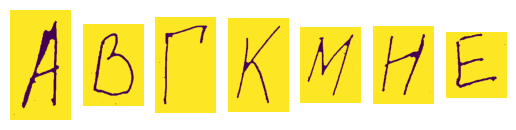

In [14]:
# display extracted images
fig, ax = plt.subplots(1, image_n_letters)
for image_letter_index, image_letter in enumerate(image_letters):
	ax[image_letter_index].imshow(image_letter)
	ax[image_letter_index].axis(False)

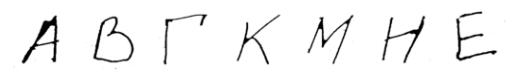

In [15]:
# display extracted transformed images
fig, ax = plt.subplots(1, image_n_letters)
for image_letter_index, image_letter in enumerate(image_letters):
	image_letter = LETTERS_TRANSFORM(image_letter).permute(1, 2, 0)
	ax[image_letter_index].imshow(image_letter)
	ax[image_letter_index].axis(False)

Image path: dataset\test\З\58beddfb6921e-13.jpeg
Image class: З
Image predict class: Д


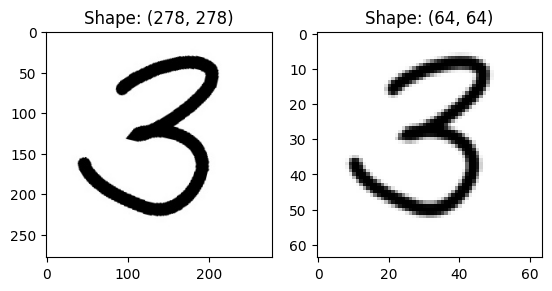

In [16]:
test_model_eval_on_random_image(image_paths, image_classes, model, MODEL_TRANSFORM)

In [17]:
def test_image_letters_step(model, transform, image_letters, image_letters_classes, image_classes):
	test_acc_list = []
	model.eval()
	with torch.inference_mode():
		for image_letter_index, image_letter in enumerate(image_letters):
			image_pred = model(transform(image_letter).unsqueeze(dim=0).to(DEVICE))
			
			image_pred_class = torch.argmax(torch.softmax(image_pred, dim=1), dim=1)
			image_pred_class = image_classes[image_pred_class]
			
			image_letter_class = image_letters_classes[image_letter_index]
			print(image_letter_class, '=', image_pred_class, end=', ')
			test_acc_list.append(image_pred_class == image_letter_class)
	print()
	return sum(test_acc_list)

In [18]:
epoch, result_acc = 0, 0
test_acc, prev_test_acc = 0, 0
while result_acc < 7:
	train_loss, train_acc = train_step(model, IMAGE_TRAIN_DATALOADER, model_loss, model_optimizer)
	test_loss, test_acc = test_step(model, IMAGE_TEST_DATALOADER, model_loss, model_optimizer)
	result_acc = test_image_letters_step(model, LETTERS_TRANSFORM, image_letters, image_letters_classes, image_classes)
	print(f"Epoch: {epoch:>2} | Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%", end=' | ')
	print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}% | Result accuaracy {result_acc} / {image_n_letters}")

	# if test_acc - prev_test_acc < 0:
	# 	print(f"Epoch: {epoch:>2} | Model Failed!")
	# 	break
	# prev_test_acc = test_acc
	
	epoch += 1

А = Ю, В = В, Г = Г, К = Н, М = Н, Н = Н, Е = Е, 
Epoch:  0 | Train loss: 2.70399 | Train accuracy: 25.24% | Test loss: 1.75809 | Test accuracy: 49.86% | Result accuaracy 4 / 7
А = Х, В = Ъ, Г = Г, К = К, М = И, Н = Н, Е = Ё, 
Epoch:  1 | Train loss: 1.31280 | Train accuracy: 62.81% | Test loss: 1.25410 | Test accuracy: 64.79% | Result accuaracy 3 / 7
А = Ж, В = В, Г = Г, К = К, М = М, Н = Н, Е = Е, 
Epoch:  2 | Train loss: 0.82964 | Train accuracy: 75.67% | Test loss: 1.04643 | Test accuracy: 70.73% | Result accuaracy 6 / 7
А = А, В = В, Г = Г, К = К, М = М, Н = Н, Е = Е, 
Epoch:  3 | Train loss: 0.49800 | Train accuracy: 84.99% | Test loss: 0.96120 | Test accuracy: 73.29% | Result accuaracy 7 / 7


In [20]:
# save model state
# torch.save(obj=model.state_dict(), f='TinyVGG_P20_H96_64x64.pth')